# 2021-05-15 R Script

### VAR Model

1. 6個變數：

    * $R$: 隔夜拆款利率(%)
    * $M$: 貨幣總計數 M2 (期底) - 去季節化後取對數
    * $CPI$: 消費者物價基本分類指數 (總指數) - 去季節化後取對數
    * $IP$: 工業生產指數 (總指數, 不含土石採 取業) - 去季節化後取對數
    * $Q$: 新台幣實質有效匯率（間接報價） - 對數
    * $PCM$ 原物料商品價格指數 (不含燃料) - 對數

2. Lag = 2

$$
\left[
\begin{array}{c}
	\varepsilon_t^R\\
    \varepsilon_t^{M}\\
	\varepsilon_t^{CPI}\\
	\varepsilon_t^{IP}\\
	\varepsilon_t^{Q}\\
	\varepsilon_t^{PCM}
\end{array}
\right]
=
\left[
\begin{array}{ccccc}
a_{11} &0 &0 &0 &0 &0\\
a_{21} &a_{22} &0 &0 &0 &0\\
a_{31} &a_{32} &a_{33} &0 &0 &0\\
a_{41} &a_{42} &a_{43} &a_{44} &0 &0\\
a_{51} &a_{52} &a_{53} &a_{54} &a_{55} &0\\
a_{61} &a_{62} &a_{63} &a_{64} &a_{65} &a_{66}\\
\end{array}
\right]
\left[
\begin{array}{c}
	e_t^{MP}\\
    e_t^{MD}\\
	e_t^{CPI}\\
	e_t^{Y}\\
	e_t^{Q}\\
	e_t^{PCM}
\end{array}
\right]
$$

### Empirical Model

\begin{align}
FXI_t = \alpha + \sum_{j=1}^P \rho_j FXI_{t-j} + \sum_{i=0}^q (\beta_i^{+} e_{t-i}^{Q+} + \beta_i^{-} e_{t-i}^{Q-}) + u_t
\end{align}

where

$FXI$: 央行干預指標

貶值衝擊: $e_t^{Q+} = max[0, e_t^{Q}]$

升值衝擊: $e_t^{Q-} = min[0, e_t^{Q}]$

### Sampling Periods

1. Chen: 1989M5-2012M2
2. Lee: 1987M1-2015M12

### 環境設定

In [1]:
getwd()

[1] "/Users/Andy 1/Google 雲端硬碟 (r08323004@g.ntu.edu.tw)/0 Semesters/RA/Pf.Huang/4_VAR_Model/0_benchmark"

In [177]:
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
# 設定路徑
#Path = "/Users/Andy 1/Google 雲端硬碟 (r08323004@g.ntu.edu.tw)/0 Semesters/Thesis/6_VAR_model/R"
#setwd(Path)
source("code/VAR_functions.R")           # 讀取 VARsource.R 檔

inv_tol = 1e-20 #求反矩陣時做數值運算允許的最小誤差(避免singular matrix)

─ Attaching packages ──────────────────── tidyverse 1.3.0 ─

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

Loading required package: matrixcalc

Loading required package: lattice



In [3]:
options(warn=-1)    # 關掉warning
#options(warn=0)
options(scipen=999) #不要科學記號

### 讀資料

In [4]:
###### 讀取資料 ######
file = "data/de_seasonalized/df.seas.csv"
data = read.csv(file = file, header = TRUE)
data$date <- as.Date(data$date)

In [5]:
data <- data %>% filter(date >= "1987-01-01" & date <= "2015-12-01")
# 6-variable model
By <- data %>% 
    select(R, M, CPI, IP, Q, PC) %>% 
    as.matrix

# Raw Data

In [6]:
# from 1987m1 to 2015m12
dim(By)
kk <- dim(By)[2]

[1] 348   6

In [7]:
draw_raw <- function(vlb_name = ""){
    vlb_name <- sym(vlb_name)
    plot.return <- data %>% 
        ggplot()+
        geom_line(aes(date, !!vlb_name))
    return(plot.return)
}

In [8]:
p1 <- draw_raw("R")
p2 <- draw_raw("M")
p3 <- draw_raw("CPI")
p4 <- draw_raw("IP")
p5 <- draw_raw("Q")
p6 <- draw_raw("PC")

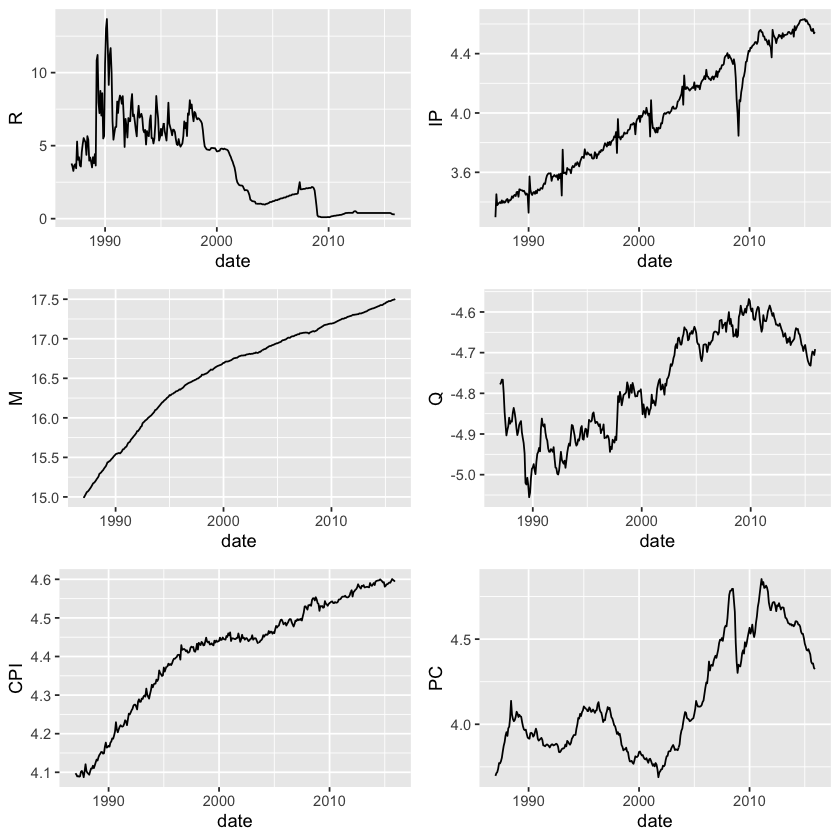

In [9]:
multiplot(p1, p2, p3, p4, p5, p6,
          cols = 2)

In [10]:
ggsave(filename = "raw.png", 
       plot = multiplot(p1, p2, p3, p4, p5, p6,
                        cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

### 模型設定

In [11]:
#----- 模型設定 -----#
VAR.P = 2                       # 最大的落後項數
CONST = TRUE                    # 是否有常數項
Y     = VAR.Y(By, VAR.P)        # 設定 Y
X     = VAR.X(By, VAR.P)        # 設定 X

In [12]:
hrz=39 # the length of response
shock_sign = -1 # control the positive/negative shock

## Reduced Form VAR

In [13]:
###### 參數估計 ######
(Coef.OLS    = VAR.OLS(Y, X, CONST)                  )
(Sigma.OLS   = VAR.Sigma.OLS(Y, X, Coef.OLS, CONST)  )
(Sigma.MLE   = VAR.Sigma.MLE(Y, X, Coef.OLS, CONST))

0.8756425018,-4.842620850,5.58410892,0.463445074,1.925634295,1.0377930439,-0.1170494047,4.69210323,-4.29422453,-1.421017021,-5.731153660,-0.626394734,-18.37112513
-0.0002355830,0.944396186,-0.00913045,0.004089628,0.010587457,-0.0007921359,-0.0005054117,0.04009519,0.04220850,-0.001678102,-0.022552577,0.002441845,0.04799969
0.0004844376,-0.036109877,0.76930057,0.022642559,0.004439544,0.0028044427,0.0003161420,0.06375804,0.10406194,-0.024324931,-0.006244284,0.002254203,0.07643382
0.0038601161,0.478118032,-0.12504906,0.437808581,-0.175489701,0.4939607929,-0.0057283792,-0.39157740,-0.01435993,0.432338268,0.192716600,-0.466347124,-0.32689038
-0.0057251915,-0.424721284,0.30824404,-0.035514166,1.128080791,-0.0118088737,0.0051899695,0.43428008,-0.31227208,0.023779011,-0.167289622,0.014683455,-0.28822811
0.0009231025,0.009890523,0.34094311,0.024310977,0.161187289,1.3182455866,-0.0013468212,0.02405071,-0.51609065,-0.031086992,-0.109047911,-0.329776914,0.53565557


0.56512781262,-0.0001824590378,0.000453997350,-0.00118020791,-0.001773271160,0.0000557821683
-0.00018245904,0.0000260660135,0.000004469611,-0.00002092157,-0.000001802925,0.0000007670033
0.00045399735,0.0000044696110,0.000044642460,-0.00006492765,-0.000048462947,0.0000162441708
-0.00118020791,-0.0000209215721,-0.000064927652,0.00152152579,0.000057580995,0.0000428514212
-0.00177327116,-0.0000018029247,-0.000048462947,0.00005758100,0.000209046434,0.0000010763389
0.00005578217,0.0000007670033,0.000016244171,0.00004285142,0.000001076339,0.0005798105111


0.54389468671,-0.0001756036405,0.000436939646,-0.00113586484,-0.001706645365,0.0000536863065
-0.00017560364,0.0000250866546,0.000004301678,-0.00002013550,-0.000001735185,0.0000007381852
0.00043693965,0.0000043016776,0.000042965142,-0.00006248817,-0.000046642085,0.0000156338407
-0.00113586484,-0.0000201355015,-0.000062488174,0.00146435864,0.000055417547,0.0000412413967
-0.00170664536,-0.0000017351847,-0.000046642085,0.00005541755,0.000201192088,0.0000010358984
0.00005368631,0.0000007381852,0.000015633841,0.00004124140,0.000001035898,0.0005580257231


### 選擇lag期數

In [14]:
# 依據AIC選擇
VAR.P = 2

# SVAR

## Identification

In [15]:
### 6-variable model

Amat = diag(6)
# Identification Conditions

Amat[2,1]  = NA; 
Amat[3,1]  = NA; Amat[3,2]  = NA; Amat[3,3]  = NA;
Amat[4,1]  = NA; Amat[4,2]  = NA; Amat[4,3]  = NA; Amat[4,3]  = NA;
Amat[5,1]  = NA; Amat[5,2]  = NA; Amat[5,3]  = NA; Amat[5,4]  = NA; Amat[5,5]  = NA;
Amat[6,1]  = NA; Amat[6,2]  = NA; Amat[6,3]  = NA; Amat[6,4]  = NA; Amat[6,5]  = NA; Amat[6,6]  = NA;

Bmat = diag(6)
diag(Bmat) = NA

Amat;Bmat

1,0,0,0,0,0
NA,1,0,0,0,0
NA,NA,NA,0,0,0
NA,NA,NA,1,0,0
NA,NA,NA,NA,NA,0
NA,NA,NA,NA,NA,NA


NA,0,0,0,0,0
0,NA,0,0,0,0
0,0,NA,0,0,0
0,0,0,NA,0,0
0,0,0,0,NA,0
0,0,0,0,0,NA


## 估計 $\hat{A} , \hat{B}$

* Recall 模型設定:

$$D(L)Y_t = Be_t$$

可以推得:

$$Y_t = \Phi_1 Y_{t-1} + \dots + \Phi_p Y_{t-p} + \varepsilon_t $$

1. 為 $A, B$ matrix 加上 zero constraints

2. 從$\Sigma_\varepsilon = CC'$知道 cholesky decomposition的 $C = (I-D_0)^{-1}B = A^{-1}B$ 

In [16]:
C.Prime <- chol(Sigma.OLS)

In [17]:
C <- t(C.Prime)
C

0.7517498338,0.0000000000,0.000000000,0.0000000000,0.000000000,0.00000000
-0.0002427124,0.0050997161,0.000000000,0.0000000000,0.000000000,0.00000000
0.0006039208,0.0009051857,0.006592297,0.0000000000,0.000000000,0.00000000
-0.0015699477,-0.0041772165,-0.009131623,0.0376593332,0.000000000,0.00000000
-0.0023588581,-0.0004658002,-0.007071397,-0.0003356769,0.012375295,0.00000000
0.0000742031,0.0001539327,0.002436180,0.0017487618,0.001546411,0.02384107


令 

$$
A = \left[
\begin{array}{ccccc}
1 &0 &0 &0 &0\\
a_{21} &1 &0 &0 &0\\
a_{31} &a_{32} &1 &0 &0\\
a_{41} &a_{42} &a_{43} &1 &0\\
a_{41} &a_{42} &a_{43} &a_{44} &1\\
\end{array}
\right]
$$

$$
B = \left[
\begin{array}{ccccc}
\sigma_1 &0 &0 &0 &0\\
0 &\sigma_2 &0 &0 &0\\
0 &0 &\sigma_3 &0 &0\\
0 &0 &0 &\sigma_4 &0\\
0 &0 &0 &0 &\sigma_5\\
\end{array}
\right]
$$

### Note: Solving system of linear equations

由於 $B, C$已知，又$AC = B$，故$A = BC^{-1}$

In [18]:
B0 <- diag(diag(C), ncol = 6, nrow = 6)
B0

0.7517498,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000
0.0000000,0.005099716,0.000000000,0.00000000,0.00000000,0.00000000
0.0000000,0.000000000,0.006592297,0.00000000,0.00000000,0.00000000
0.0000000,0.000000000,0.000000000,0.03765933,0.00000000,0.00000000
0.0000000,0.000000000,0.000000000,0.00000000,0.01237529,0.00000000
0.0000000,0.000000000,0.000000000,0.00000000,0.00000000,0.02384107


In [19]:
A0 <- B0 %*% solve(C)
A0

1.0000000000,0.00000000,0.0000000,0.00000000000000000000000,0.0000000,0
0.0003228633,1.00000000,0.0000000,0.00000000000000000000000,0.0000000,0
-0.0008606608,-0.17749727,1.0000000,-0.00000000000000008014917,0.0000000,0
0.0011606671,0.57323913,1.3851960,0.99999999999999988897770,0.0000000,0
0.0022544487,-0.09394898,1.0850227,0.00891351218968998264269,1.0000000,0
-0.0001260079,0.02053014,-0.5694568,-0.04755017269239773108902,-0.1249595,1


In [20]:
SVAR_AB_est <- list("A0.svar" = A0, "B0.svar" = B0)

## IRF (without Bootstrap C.I.)

In [21]:
### IRF
SVAR_AB_IRF <- VAR.svarirf.AB(By, VAR.P, Amat, Bmat, h = hrz, CONST, SVAR_AB_est = SVAR_AB_est)


# 6*6個圖的time series
df_IRF_plot <- matrix(NA, hrz+1, kk^2) #%>% as.tibble() ## hrz+1
#dim(df_IRF_plot)
h <- 0 # h表示第幾期的IRF
for(period in SVAR_AB_IRF){
  k <- 0 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
  h <- h+1 # h表示第幾期的IRF
  for(j in 1:kk){
    for(i in 1:kk){
      k <- k+1 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
      df_IRF_plot[h,k] <- period[i,j]
    }
  }
}
df_IRF_plot <- df_IRF_plot %>% as_tibble()

In [22]:
kk*1:kk

[1]  6 12 18 24 30 36

In [23]:
#output entire table
IRF_TABLE <- df_IRF_plot[,kk*1:kk] %>% select(mp = 1,
                                              md = 2,
                                              cpi = 3,
                                              y = 4,
                                              q = 5,
                                              pcm = 6)
write.table(IRF_TABLE, file = "result/table/IRF_TABLE.csv", sep = ",", row.names = FALSE)

In [24]:
draw_IRF <- function(df = df_IRF_plot, V1 = 1){
    V1 <- paste0("V", V1) %>% sym()
    plot.return <- ggplot(df) + 
        geom_line(aes(x = 1:nrow(df), y = !!V1))
    return(plot.return)
}

In [25]:
for(i in 1:(kk^2)){
    assign(paste0("p",i), draw_IRF(df_IRF_plot, i))
}

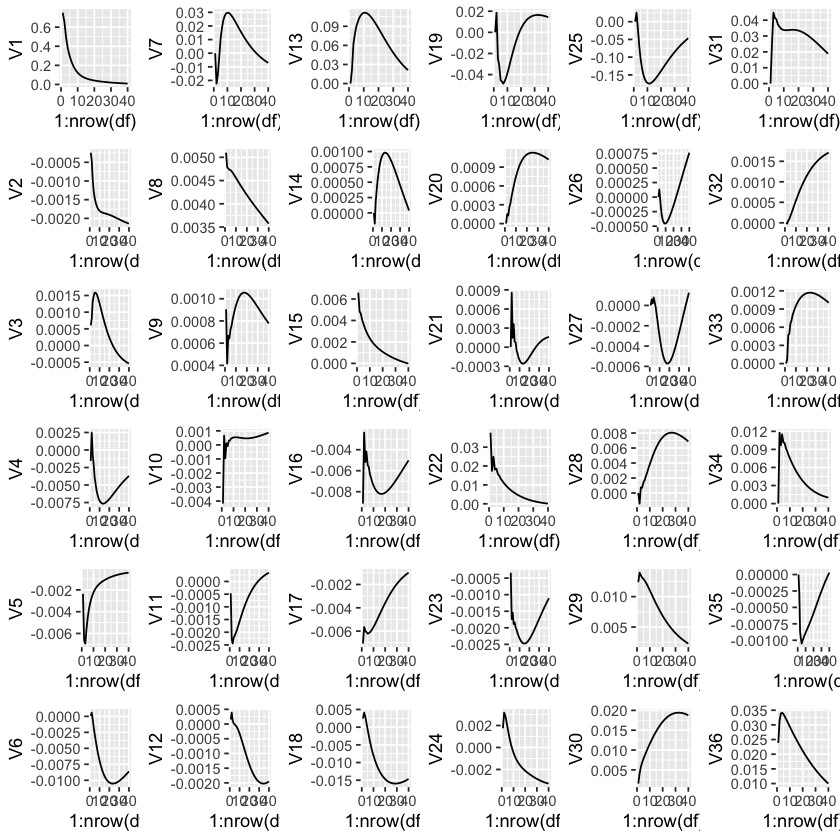

In [26]:
multiplot(p1,p2,p3,p4,p5,p6,
          p7,p8,p9,p10,p11,p12,
          p13,p14,p15,p16,p17,p18,
          p19,p20,p21,p22,p23,p24,
          p25,p26,p27,p28,p29,p30,
          p31,p32,p33,p34,p35,p36,
          cols = 6)

## IRF (Bootstrap C.I.)

Steps:

1. 從殘差取後放回重抽T個

2. 從估計值加上重抽的T個殘差，得到5條 period為T的pseudo time series

3. 從pseudo time series再估SVAR及IRF

    a. 估的時候要用重新估計的 $\hat{A}, \hat{B}$ matrix來計算IRF
    
    b. 估的條件相似，是當重抽一組residual並得到pseudo time series後，一樣要 $se(\hat{A}), se(\hat{B})$ 存在才算進一個bootstrap statistics
    
    c. 停止條件是蒐集到1000條

4. 從IRF的2.5% quantile跟97.5%quantile找到IRF的95% C.I.

存法：用arrary：

1. row數為總期間減去lag期數

2. column數為變數總數的平方（shock1對y1,..., shock5對y5）

3. page數為Bootstrap重複的次數

# Bootstrap C.I.

* http://www.eviews.com/help/helpintro.html#page/content%2Fmodels-Solving_the_Model.html%23ww100137

```R
lower = 0.025                                        # 控制成 95% CI
upper = 1-lower
kk = ncol(By)
ddY = VAR.ddY(By, VAR.P)
ddX = VAR.ddX(By, VAR.P)

# dim(ddY); dim(ddX)

T   = nrow(ddY)
T.total= nrow(By)
Ik  = diag(rep(1, kk))
# 16 coef if 4 variables; 55 coef if 5 variables
Coef = t(VAR.EbyE(ddY, ddX, CONST)$ddA)              # Step 1 估計模型
# residuals
U    = VAR.EbyE(ddY, ddX, CONST)$ddU
BSigma.u = VAR.ddSigma.OLS(ddY, ddX, CONST)
if(CONST == TRUE){
  const = Coef[, ncol(Coef)]
  Coef.noc= Coef[,-ncol(Coef)]                      # 刪掉 const
}else{
  const = matrix(0, kk, 1)
  Coef.noc = Coef
}

Theta.unit= VAR.Theta(Coef, h, BSigma.u, CONST)$unit # 估算 Theta.unit
Theta.std = VAR.Theta(Coef, h, BSigma.u, CONST)$std  # 估算 Theta.std

# dm.U <- U-mean(U)
dm.U <- U

N = 2000 #重抽次數
Theta.unit.sim = vector("list", N)
Theta.std.sim  = vector("list", N)

# check dimension
print("check dimensionality")
dim(ddX); dim(Coef.noc); dim(dm.U)


# 存N次重抽的IRF
df_IRF.sim <- array(NA, c(hrz+1,kk^2,N)) #dimensions are: Time Period, Number of shock interacts with variables, page (number of Bootstrap resamplings)
counter <- 1
while(TRUE){

  #cat("Now, there are ", counter-1, " sets of resamples.\n")
  Y.sim = matrix(0, nrow = T.total, ncol = kk)          # Y.sim = 0 #pseudo time series
  Y.sim[c(1:VAR.P),] = By[c(1:VAR.P), ] #initial values

  boot.number = sample(c(1:T), replace = TRUE)      # Step 3 取出放回
  U.sim = dm.U[boot.number,]

    # predicted values given the above initial values
    last.y= c(t(By[VAR.P:1,]))
    for(ii in 1:T){
         last.y = last.y[1:(kk*VAR.P)]
         Y.sim[ii+VAR.P, ] = Coef.noc %*% last.y + const + U.sim[ii,]      # Step 4 模擬資料
         last.y = c(Y.sim[ii+VAR.P,], last.y)
      }
  
#   Y.sim[-c(1:VAR.P),] <- matrix(const, nrow = T.total-VAR.P, ncol = kk, byrow = T) + ddX %*% t(Coef.noc) + U.sim
  
    
  #`Y.sim` is the pseudo time series
  # Step 5 重新估算SVAR
  
  ### SVAR.sim Start ###

    Y_pseudo     = VAR.Y(Y.sim, VAR.P)        # 設定 Y
    X_pseudo     = VAR.X(Y.sim, VAR.P)        # 設定 X
    Coef.OLS_pseudo    = VAR.OLS(Y_pseudo, X_pseudo, CONST)
    Sigma.OLS_pseudo   = VAR.Sigma.OLS(Y_pseudo, X_pseudo, Coef.OLS_pseudo, CONST)
    C.Prime_pseudo <- chol(Sigma.OLS_pseudo)
    C_pseudo <- t(C.Prime_pseudo)
    B0_pseudo <- diag(diag(C_pseudo), ncol = kk, nrow = kk)
    A0_pseudo <- B0_pseudo %*% solve(C_pseudo)
    SVAR_AB_est.sim <- list("A0.svar" = A0_pseudo, "B0.svar" = B0_pseudo)
    SVAR_AB_IRF.sim <- VAR.svarirf.AB(Y.sim, VAR.P, Amat, Bmat, h = hrz, CONST, SVAR_AB_est = SVAR_AB_est.sim)
    
  # 5*5個圖的time series
  df_IRF_plot.sim <- matrix(NA, hrz+1, kk^2) #%>% as.tibble()
  # df_IRF.sim <- array(1:(120*25*N), c(120,25,N))
  # df_IRF.sim[2,1,1] # slicing
  
  h <- 0 # h表示第幾期的IRF
  for(period in SVAR_AB_IRF.sim){
    k <- 0 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
    h <- h+1 # h表示第幾期的IRF
    for(j in 1:kk){
      for(i in 1:kk){
        k <- k+1 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
        df_IRF_plot.sim[h,k] <- period[i,j]
      }
    }
  }
  # 把這一次重抽得到的IRF append進`df_IRF.sim`中
  df_IRF.sim[,,counter] <- df_IRF_plot.sim
  ### SVAR.sim Ends ###
  if(counter>=N){
    break
  }
  counter <- counter+1
}
```

```R
# Save
saveRDS(df_IRF.sim, file = "df_IRF.sim.rds")
```

In [29]:
df_IRF.sim <- read_rds("df_IRF.sim.rds")

In [30]:
# 看某一頁
head(df_IRF.sim[,,1000])
print(sum(is.na(df_IRF.sim)))

0.7550792,-0.0002307034,0.0005876932,-0.001689966,-0.002354624,-0.0008854781,0.00000000,0.005274332,0.0008122899,-0.0006043783,⋯,-0.000000000000000002331933,0.000000000000000001326655,0.011890111,0.0002780822,0.00000000,0.0000000000,0.0000000000,0.000000000,0.0000000000,0.01971225
0.6768434,-0.0006296754,0.0011513673,0.002575059,-0.007752362,-0.0005621878,0.04245362,0.005229547,0.0006245101,0.0037834398,⋯,0.000222590477734541862358,-0.000044689925332726578575,0.011906664,0.0023789592,0.02413681,0.0001688783,-0.0002020104,0.009499212,0.0014594476,0.02513558
0.4694994,-0.0014850347,0.0013537019,-0.001424815,-0.007639673,-0.0023159426,0.04180752,0.005179191,0.0008514565,0.0023984502,⋯,0.000288741898829622133018,0.001825614798332314677939,0.010181731,0.0038972241,0.07056484,0.0003180527,0.0002109646,0.007338149,0.0011883556,0.02701386
0.3105722,-0.0020186946,0.0011655652,-0.003220339,-0.005526115,-0.0049128439,0.04379250,0.005198255,0.0008464302,0.0027744663,⋯,0.000321369128093460432096,0.001482492373278967599456,0.009402813,0.0047020066,0.05520520,0.0003262458,0.0001877232,0.009115581,0.0009317911,0.02696885
0.2219370,-0.0023133276,0.0010470068,-0.005476368,-0.003995568,-0.0070216773,0.05490357,0.005231602,0.0009405382,0.0021513280,⋯,0.000233742565484258268266,0.001733461945970648761597,0.009067452,0.0051668741,0.03888365,0.0003073103,0.0003268676,0.007615206,0.0008046280,0.02630116
0.1619562,-0.0025146717,0.0008717163,-0.006272180,-0.003112258,-0.0086030874,0.05901473,0.005239641,0.0009886038,0.0021251643,⋯,0.000163265707847774646858,0.001766665028932649407489,0.008614635,0.0056498698,0.01862269,0.0003025917,0.0003183335,0.007442337,0.0008673736,0.02529514


[1] 0


### 畫IRF & Bootstrap C.I.

In [31]:
df_IRF_plot.BS.L <- matrix(NA, nrow = hrz+1, ncol = kk^2)
df_IRF_plot.BS.U <- matrix(NA, nrow = hrz+1, ncol = kk^2)
df_IRF_plot.BS.Median <- matrix(NA, nrow = hrz+1, ncol = kk^2)
df_IRF_plot.BS.Mean <- matrix(NA, nrow = hrz+1, ncol = kk^2)
for(col in 1:(kk^2)){
  for(row in 1:(hrz+1) ){
    df_IRF_plot.BS.L[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.025)
    df_IRF_plot.BS.U[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.975)
    df_IRF_plot.BS.Median[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.5)
    df_IRF_plot.BS.Mean[row,col] <- mean(df_IRF.sim[row,col,])
  }
}

df_IRF_plot.BS.L <- df_IRF_plot.BS.L %>% as_tibble()
df_IRF_plot.BS.U <- df_IRF_plot.BS.U %>% as_tibble()
df_IRF_plot.BS.Median <- df_IRF_plot.BS.Median %>% as_tibble()
df_IRF_plot.BS.Mean <- df_IRF_plot.BS.Mean %>% as_tibble()

In [ ]:
ind <- 0
for(i in 1:kk){
  for(j in 1:kk){
    ind <- ind+1
    nam <- paste("shock", j, "y", i, sep = '')
    assign(nam, bind_cols(df_IRF_plot.BS.L[ind], df_IRF_plot.BS.U[ind],
                          df_IRF_plot.BS.Median[ind], df_IRF_plot.BS.Mean[ind],
                          df_IRF_plot[ind]))
    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Median', 'Mean', 'Actual')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") +geom_hline(yintercept=0, color = 'grey')+ geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Median), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

In [33]:
Text_Size_Theme = theme(
  axis.title.x = element_text(size = 12),
  axis.text.x = element_text(size = 12),
  axis.title.y = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size=12))

add_layout <- function(p = p1,
                       response_of = "this variable", react_to = "the shock"){
    title_text <- paste("Response of", response_of, "to", react_to, sep = ' ')
    plot.return <- p + labs(x = "Month", y = "", title = title_text) + Text_Size_Theme
    return(plot.return)
}

In [34]:
vlb_list = c("R",
             "M2",
             "CPI",
             "IP",
             "Q",
             "PCM")

In [35]:
p1 <- add_layout(p1, vlb_list[1], "monetary policy shock")
p2 <- add_layout(p2, vlb_list[2], "monetary policy shock")
p3 <- add_layout(p3, vlb_list[3], "monetary policy shock")
p4 <- add_layout(p4, vlb_list[4], "monetary policy shock")
p5 <- add_layout(p5, vlb_list[5], "monetary policy shock")
p6 <- add_layout(p6, vlb_list[6], "monetary policy shock")

p7 <- add_layout(p7, vlb_list[1], "MD shock")
p8 <- add_layout(p8, vlb_list[2], "MD shock")
p9 <- add_layout(p9, vlb_list[3], "MD shock")
p10 <- add_layout(p10, vlb_list[4], "MD shock")
p11 <- add_layout(p11, vlb_list[5], "MD shock")
p12 <- add_layout(p12, vlb_list[6], "MD shock")

p13 <- add_layout(p13, vlb_list[1], "CPI shock")
p14 <- add_layout(p14, vlb_list[2], "CPI shock")
p15 <- add_layout(p15, vlb_list[3], "CPI shock")
p16 <- add_layout(p16, vlb_list[4], "CPI shock")
p17 <- add_layout(p17, vlb_list[5], "CPI shock")
p18 <- add_layout(p18, vlb_list[6], "CPI shock")

p19 <- add_layout(p19, vlb_list[1], "output shock")
p20 <- add_layout(p20, vlb_list[2], "output shock")
p21 <- add_layout(p21, vlb_list[3], "output shock")
p22 <- add_layout(p22, vlb_list[4], "output shock")
p23 <- add_layout(p23, vlb_list[5], "output shock")
p24 <- add_layout(p24, vlb_list[6], "output shock")

p25 <- add_layout(p25, vlb_list[1], "exchange rate shock")
p26 <- add_layout(p26, vlb_list[2], "exchange rate shock")
p27 <- add_layout(p27, vlb_list[3], "exchange rate shock")
p28 <- add_layout(p28, vlb_list[4], "exchange rate shock")
p29 <- add_layout(p29, vlb_list[5], "exchange rate shock")
p30 <- add_layout(p30, vlb_list[6], "exchange rate shock")

p31 <- add_layout(p31, vlb_list[1], "commodity price shock")
p32 <- add_layout(p32, vlb_list[2], "commodity price shock")
p33 <- add_layout(p33, vlb_list[3], "commodity price shock")
p34 <- add_layout(p34, vlb_list[4], "commodity price shock")
p35 <- add_layout(p35, vlb_list[5], "commodity price shock")
p36 <- add_layout(p36, vlb_list[6], "commodity price shock")

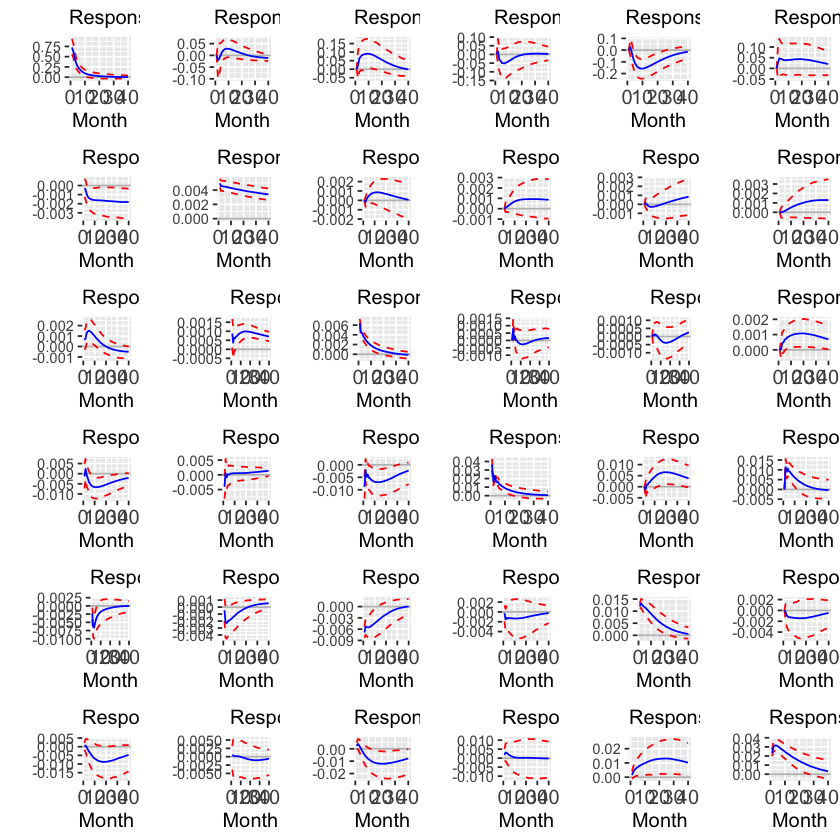

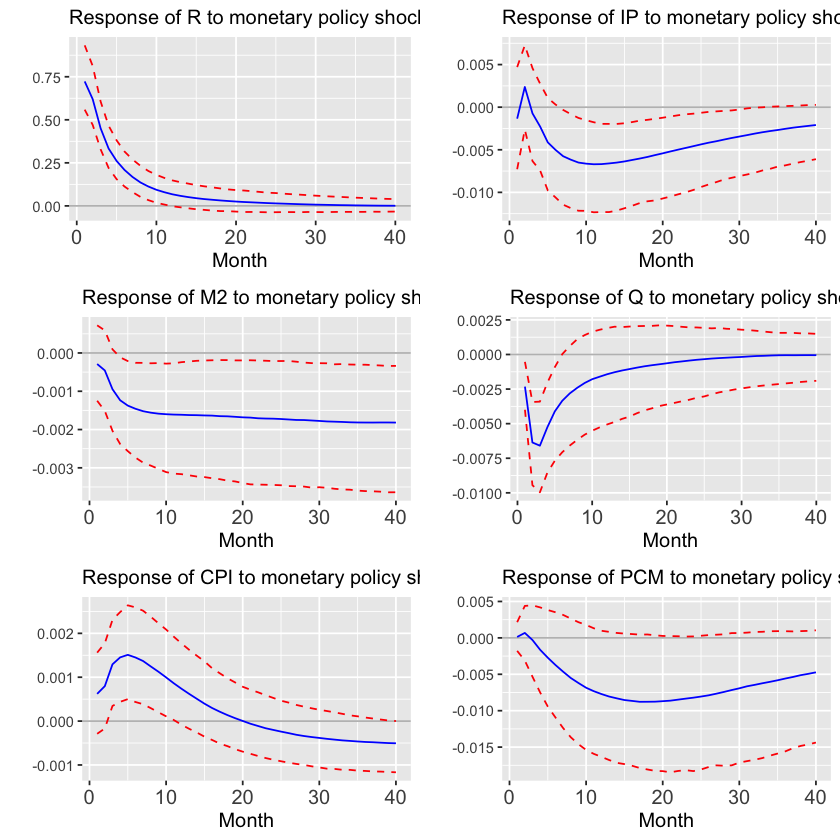

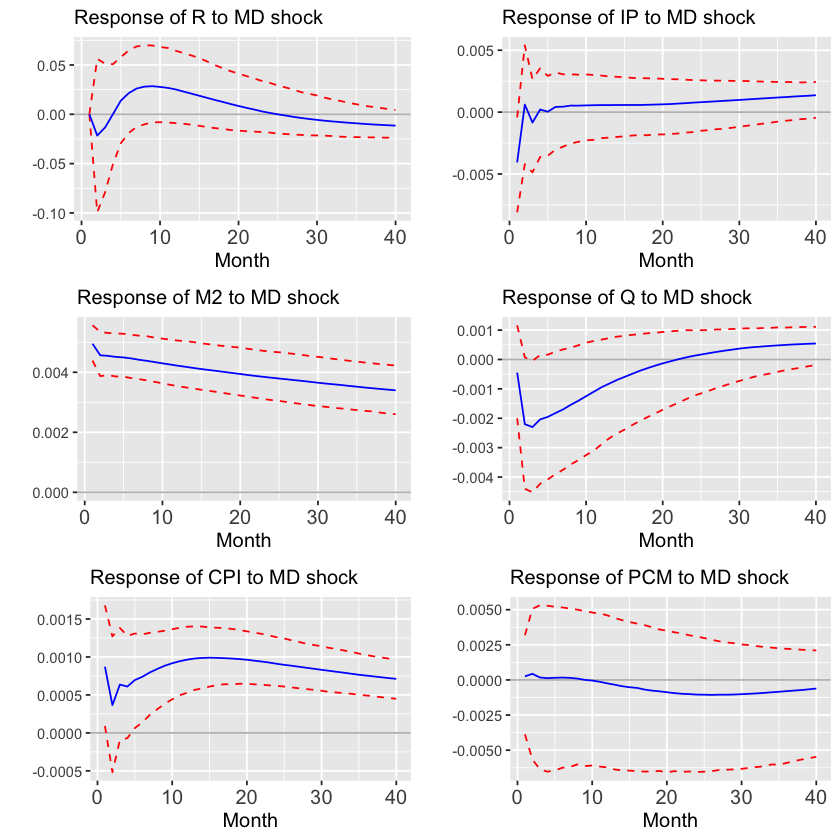

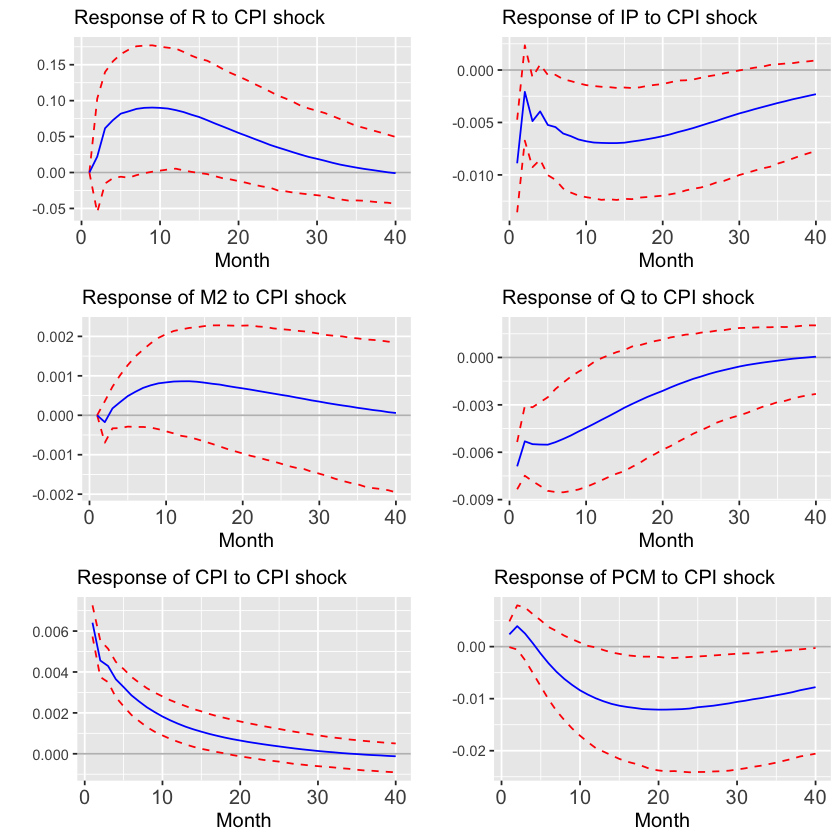

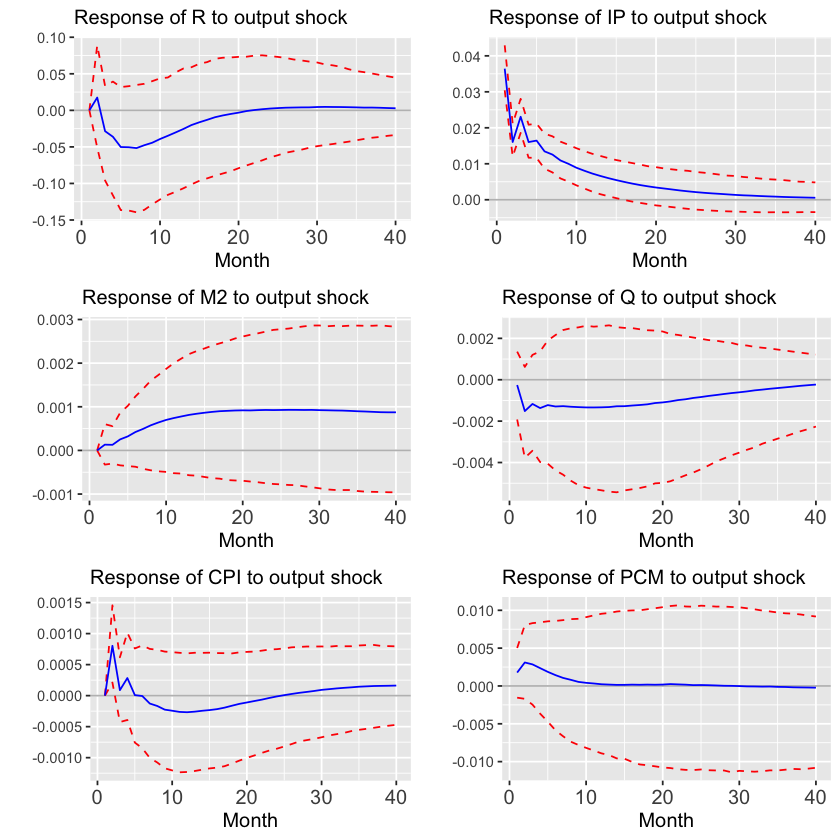

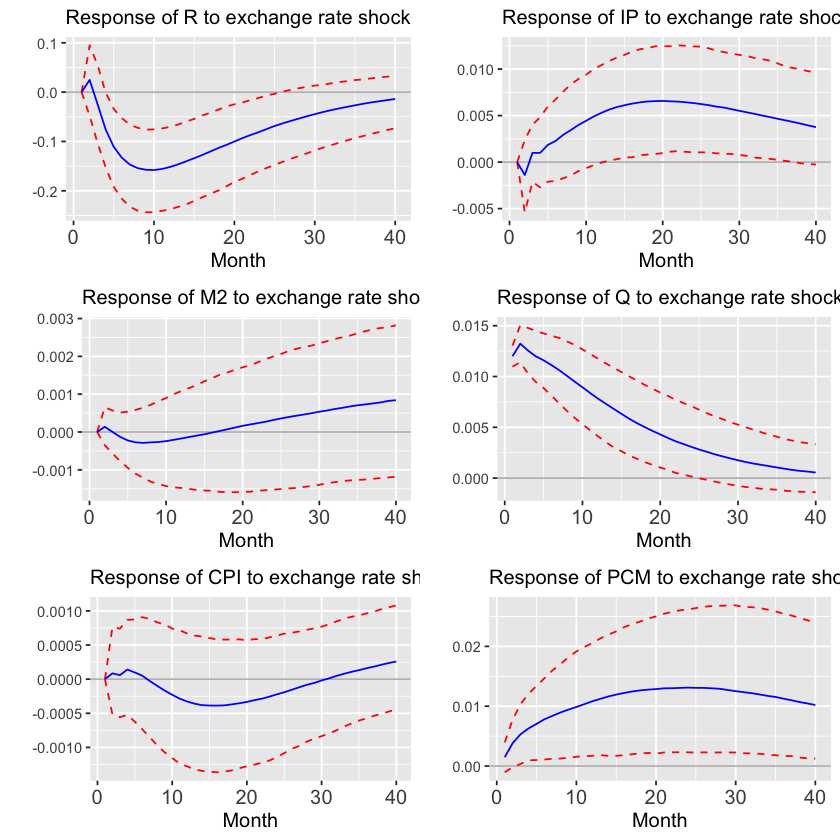

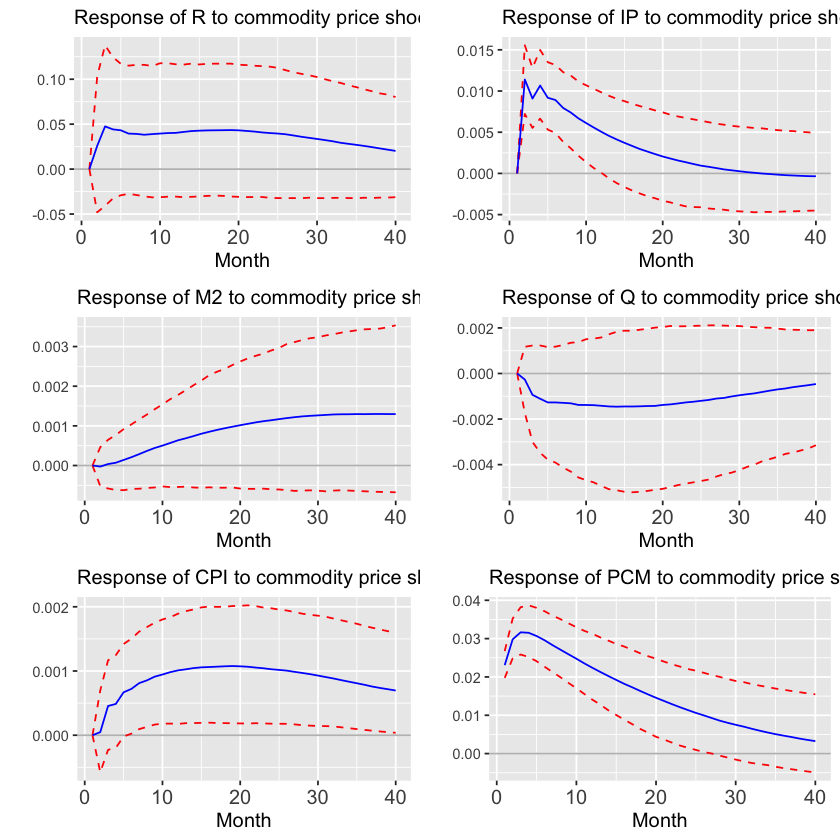

In [36]:
multiplot(p1,p2,p3,p4,p5,p6,
          p7,p8,p9,p10,p11,p12,
          p13,p14,p15,p16,p17,p18,
          p19,p20,p21,p22,p23,p24,
          p25,p26,p27,p28,p29,p30,
          p31,p32,p33,p34,p35,p36,
          cols = 6)
# For shock 1
multiplot(p1,p2,p3,p4,p5,p6, cols = 2)
ggsave(filename = "result/figure/IRF_shock1.png", 
       plot = multiplot(p1,p2,p3,p4,p5,p6, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")
# For shock 2
multiplot(p7,p8,p9,p10,p11,p12, cols = 2)
ggsave(filename = "result/figure/IRF_shock2.png", 
       plot = multiplot(p7,p8,p9,p10,p11,p12, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")
# For shock 3
multiplot(p13,p14,p15,p16,p17,p18, cols = 2)
ggsave(filename = "result/figure/IRF_shock3.png", 
       plot = multiplot(p13,p14,p15,p16,p17,p18, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")
# For shock 4
multiplot(p19,p20,p21,p22,p23,p24, cols = 2)
ggsave(filename = "result/figure/IRF_shock4.png", 
       plot = multiplot(p19,p20,p21,p22,p23,p24, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")
# For shock 5
multiplot(p25,p26,p27,p28,p29,p30, cols = 2)
ggsave(filename = "result/figure/IRF_shock5.png", 
       plot = multiplot(p25,p26,p27,p28,p29,p30, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")
# For shock 6
multiplot(p31,p32,p33,p34,p35,p36, cols = 2)
ggsave(filename = "result/figure/IRF_shock6.png", 
       plot = multiplot(p31,p32,p33,p34,p35,p36, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

### Obtain the exogenous shock

In [43]:
Coef.noc

0.8756425018,-4.842620811,5.584108942,0.463445075,1.925634302,1.0377930446,-0.1170494047,4.69210319,-4.29422455,-1.421017021,-5.731153666,-0.626394735
-0.0002355830,0.944396169,-0.009130445,0.004089628,0.010587458,-0.0007921362,-0.0005054117,0.04009520,0.04220849,-0.001678103,-0.022552578,0.002441845
0.0004844376,-0.036109882,0.769300567,0.022642559,0.004439544,0.0028044427,0.0003161420,0.06375804,0.10406193,-0.024324931,-0.006244284,0.002254203
0.0038601161,0.478118020,-0.125049062,0.437808581,-0.175489702,0.4939607928,-0.0057283792,-0.39157738,-0.01435993,0.432338268,0.192716600,-0.466347124
-0.0057251915,-0.424721283,0.308244039,-0.035514166,1.128080791,-0.0118088736,0.0051899695,0.43428008,-0.31227208,0.023779011,-0.167289623,0.014683455
0.0009231025,0.009890519,0.340943116,0.024310977,0.161187289,1.3182455866,-0.0013468212,0.02405072,-0.51609065,-0.031086992,-0.109047912,-0.329776914


In [44]:
Coef.OLS #What we want is the 5th row

0.8756425018,-4.842620850,5.58410892,0.463445074,1.925634295,1.0377930439,-0.1170494047,4.69210323,-4.29422453,-1.421017021,-5.731153660,-0.626394734,-18.37112513
-0.0002355830,0.944396186,-0.00913045,0.004089628,0.010587457,-0.0007921359,-0.0005054117,0.04009519,0.04220850,-0.001678102,-0.022552577,0.002441845,0.04799969
0.0004844376,-0.036109877,0.76930057,0.022642559,0.004439544,0.0028044427,0.0003161420,0.06375804,0.10406194,-0.024324931,-0.006244284,0.002254203,0.07643382
0.0038601161,0.478118032,-0.12504906,0.437808581,-0.175489701,0.4939607929,-0.0057283792,-0.39157740,-0.01435993,0.432338268,0.192716600,-0.466347124,-0.32689038
-0.0057251915,-0.424721284,0.30824404,-0.035514166,1.128080791,-0.0118088737,0.0051899695,0.43428008,-0.31227208,0.023779011,-0.167289622,0.014683455,-0.28822811
0.0009231025,0.009890523,0.34094311,0.024310977,0.161187289,1.3182455866,-0.0013468212,0.02405071,-0.51609065,-0.031086992,-0.109047911,-0.329776914,0.53565557


In [52]:
const

[1] -18.37112513   0.04799969   0.07643382  -0.32689038  -0.28822811
[6]   0.53565557

In [97]:
# check the order of variables is correct
lm(Q ~ lag(R)+lag(M)+lag(CPI)+lag(IP)+lag(Q)+lag(PC)
   +lag(R, n=2)+lag(M, n=2)+lag(CPI, n=2)+lag(IP, n=2)+lag(Q, n=2)+lag(PC, n=2),
   data = data)


Call:
lm(formula = Q ~ lag(R) + lag(M) + lag(CPI) + lag(IP) + lag(Q) + 
    lag(PC) + lag(R, n = 2) + lag(M, n = 2) + lag(CPI, n = 2) + 
    lag(IP, n = 2) + lag(Q, n = 2) + lag(PC, n = 2), data = data)

Coefficients:
    (Intercept)           lag(R)           lag(M)         lag(CPI)  
      -0.288228        -0.005725        -0.424721         0.308244  
        lag(IP)           lag(Q)          lag(PC)    lag(R, n = 2)  
      -0.035514         1.128081        -0.011809         0.005190  
  lag(M, n = 2)  lag(CPI, n = 2)   lag(IP, n = 2)    lag(Q, n = 2)  
       0.434280        -0.312272         0.023779        -0.167290  
 lag(PC, n = 2)  
       0.014683  


In [127]:
get_residual <- function(vlb_order = 1){
    X.Mat <- By %>% as_tibble() %>%
    mutate(V1 = lag(R),
           V2 = lag(M),
           V3 = lag(CPI),
           V4 = lag(IP),
           V5 = lag(Q),
           V6 = lag(PC),
           V7 = lag(R, n = 2),
           V8 = lag(M, n = 2),
           V9 = lag(CPI, n = 2),
           V10 = lag(IP, n = 2),
           V11 = lag(Q, n = 2),
           V12 = lag(PC, n = 2),
           V13 = rep(1, nrow(By))
          ) %>%
    select(V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13
          ) %>%
    drop_na() %>%
    as.matrix
    Y.Mat <- By[(VAR.P+1):nrow(By),vlb_order] %>% as.matrix
    Y.Mat_hat <- X.Mat %*% (Coef.OLS[vlb_order, ] %>% as.matrix)
    residual <- Y.Mat - Y.Mat_hat
    return(residual)
}

In [130]:
# resid1 <- get_residual(1)
for(i in 1:6){
    assign(paste0("resid_",i), get_residual(i))
}

In [148]:
resid.Mat <- cbind(resid_1, resid_2, resid_3, resid_4, resid_5, resid_6)

In [152]:
error.Mat <- (solve(B0) %*% A0 %*% t(resid.Mat)) %>% t()

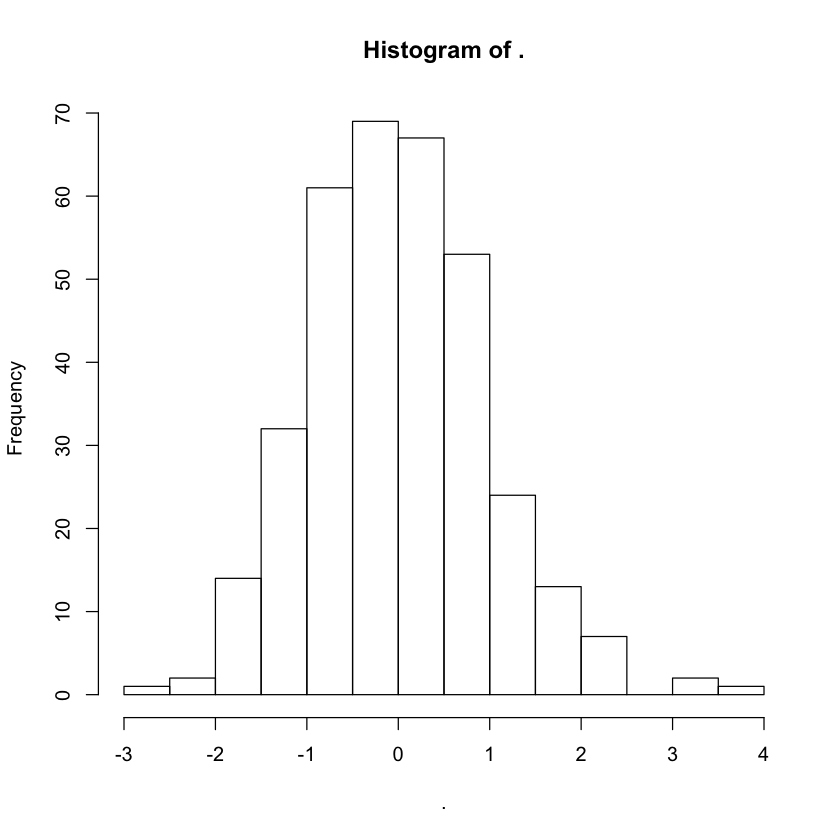

In [157]:
error.Mat[,5] %>% hist

### Extract the exchange rate shock

In [174]:
# error.Mat %>% as_tibble() %>%
#     select(e1 = 1, e2 = 2, e3 = 3, e4 = 4, e5 = 5, e6 = 6) %>%
#     mutate(no = row_number()) %>%
#     ggplot()+
#     geom_line(aes(no, e5))

In [178]:
data.err <- data %>% 
    bind_cols(e5 = c(rep(NA, VAR.P), error.Mat[,5])) %>%
    mutate(e5_pos = fifelse(e5 > 0, e5, 0),
           e5_neg = fifelse(e5 < 0, e5, 0))

In [179]:
data.err %>% head(10)

,date,R,M,CRM,CPI,IP,PC,OP,Q,Interv,e5,e5_pos,e5_neg
,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1987-01-01,3.78,14.99887,98289,4.097422,3.297288,3.697011,3.200875,-4.778115,2509.142234,NA,NA,NA
2,1987-02-01,3.57,14.99637,95552,4.094307,3.451879,3.712547,3.164087,-4.773900,2451.115885,NA,NA,NA
3,1987-03-01,3.27,15.01735,93140,4.089297,3.378369,3.718553,3.186440,-4.766353,2375.788935,0.57935549,0.5793555,0.00000000
4,1987-04-01,3.65,15.03842,96412,4.090163,3.386314,3.739055,3.182150,-4.766609,2438.274088,1.36838565,1.3683856,0.00000000
5,1987-05-01,3.73,15.06081,71812,4.088595,3.393408,3.772173,3.201981,-4.798679,1805.017673,-1.23355755,0.0000000,-1.23355755
6,1987-06-01,3.45,15.06794,43939,4.089535,3.399108,3.770240,3.215670,-4.846154,1053.943667,-1.99113984,0.0000000,-1.99113984
7,1987-07-01,5.28,15.07934,10943,4.101172,3.391256,3.782257,3.258171,-4.875808,-5.129039,-0.08995268,0.0000000,-0.08995268
8,1987-08-01,4.03,15.09583,65390,4.103509,3.410870,3.803005,3.223135,-4.903495,1529.275622,-0.70302965,0.0000000,-0.70302965
9,1987-09-01,4.21,15.11214,56837,4.097608,3.394140,3.840639,3.196405,-4.890274,1317.541926,1.00765498,1.0076550,0.00000000


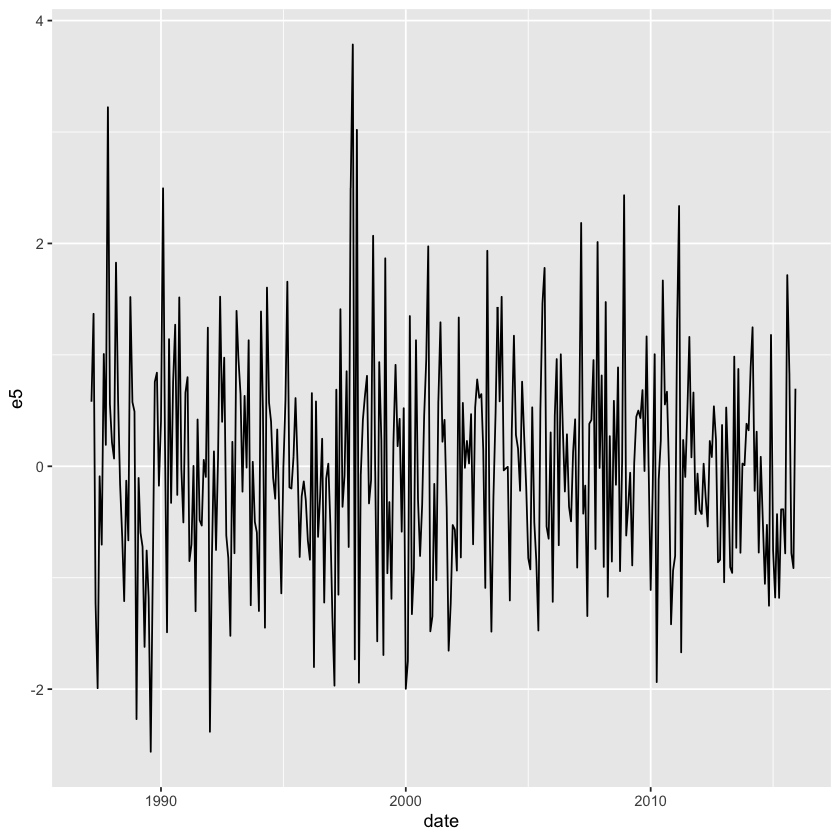

In [173]:
data.err %>% ggplot()+
    geom_line(aes(date, e5))

## Regression

* asymmetric:

\begin{align}
FXI_t = \alpha + \sum_{j=1}^P \rho_j FXI_{t-j} + \sum_{i=0}^q (\beta_i^{+} e_{t-i}^{Q+} + \beta_i^{-} e_{t-i}^{Q-}) + u_t
\end{align}

* symmetric:

\begin{align}
FXI_t = \alpha + \rho_1 FXI_{t-1} + \beta_0 e_t^Q + u_t
\end{align}

#### Questions

1. How to calculate $FXI_t$?

    使用已剔除匯率變動因素的「準備貨幣增減因素 -- 國外資產」（金融統計月報表4），並以央行國外資產在 1986 年 12 月的存量為起始點，將「準備貨幣增減因素 -- 國外資產」此資料的流量累加，以得到一個排除掉匯率影響的央行國外資產存量之衡量
    
    e.g.
    https://www.cbc.gov.tw/public/data/EBOOKXLS/015_EF13_A4L.pdf
    
    In footnote: 若 $X_0$ 代表 1986 年 12 月的央行國外資產, $􏰭Z_t$ 代表準備貨幣增減因素 (國外資產), 則 $FXI_t = \Delta 􏰭log[X_0 + 􏰲\sum_{s=1} \Delta􏰭 Z_s]\times 100$


In [180]:
# consider 
# p = 1, q = 0
reg1 <- lm(CRM ~ lag(CRM) + e5_pos + e5_neg, data = data.err)
summary(reg1)


Call:
lm(formula = CRM ~ lag(CRM) + e5_pos + e5_neg, data = data.err)

Residuals:
    Min      1Q  Median      3Q     Max 
-195802  -27444   -4858   25444  276201 

Coefficients:
                Estimate   Std. Error t value            Pr(>|t|)    
(Intercept)   8423.62537   4964.71709   1.697              0.0907 .  
lag(CRM)         0.60318      0.04308  14.000 <0.0000000000000002 ***
e5_pos         279.60674   5215.14490   0.054              0.9573    
e5_neg      -13912.86834   5881.26249  -2.366              0.0186 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53040 on 342 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:   0.37,	Adjusted R-squared:  0.3644 
F-statistic: 66.94 on 3 and 342 DF,  p-value: < 0.00000000000000022


In [181]:
# consider
# p = q = 4
reg2 <- lm(CRM ~ lag(CRM) + lag(CRM, 2) + lag(CRM, 3) + lag(CRM, 4)
           + e5_pos + lag(e5_pos, 1) + lag(e5_pos, 2) + lag(e5_pos, 3) + lag(e5_pos, 4)
           + e5_neg + lag(e5_neg, 1) + lag(e5_neg, 2) + lag(e5_neg, 3) + lag(e5_neg, 4), 
           data = data.err)
summary(reg2)


Call:
lm(formula = CRM ~ lag(CRM) + lag(CRM, 2) + lag(CRM, 3) + lag(CRM, 
    4) + e5_pos + lag(e5_pos, 1) + lag(e5_pos, 2) + lag(e5_pos, 
    3) + lag(e5_pos, 4) + e5_neg + lag(e5_neg, 1) + lag(e5_neg, 
    2) + lag(e5_neg, 3) + lag(e5_neg, 4), data = data.err)

Residuals:
    Min      1Q  Median      3Q     Max 
-187038  -26164   -1260   24427  222134 

Coefficients:
                   Estimate   Std. Error t value             Pr(>|t|)    
(Intercept)      8489.33104   7988.46773   1.063              0.28870    
lag(CRM)            0.50453      0.05523   9.135 < 0.0000000000000002 ***
lag(CRM, 2)         0.05682      0.06125   0.928              0.35429    
lag(CRM, 3)         0.19728      0.06151   3.207              0.00147 ** 
lag(CRM, 4)        -0.04441      0.05565  -0.798              0.42546    
e5_pos            656.81201   5195.56554   0.126              0.89948    
lag(e5_pos, 1)   5724.51954   5172.69636   1.107              0.26925    
lag(e5_pos, 2)    203.88143   5170.

In [182]:
reg3 <- lm(CRM ~ lag(CRM) + e5, data = data.err)
summary(reg3)


Call:
lm(formula = CRM ~ lag(CRM) + e5, data = data.err)

Residuals:
    Min      1Q  Median      3Q     Max 
-197227  -26184   -3999   25113  271117 

Coefficients:
               Estimate  Std. Error t value             Pr(>|t|)    
(Intercept) 14084.45026  3240.44710   4.346            0.0000183 ***
lag(CRM)        0.59698     0.04296  13.895 < 0.0000000000000002 ***
e5          -6228.41732  2911.77409  -2.139               0.0331 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53130 on 343 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.3658,	Adjusted R-squared:  0.3621 
F-statistic: 98.92 on 2 and 343 DF,  p-value: < 0.00000000000000022
